In [1]:
from src.utilities.plotting_utils import get_chemi_colors
import os
import plotly
import plotly.graph_objects as go
from IPython.display import display, HTML
import numpy as np
import os
import pandas as pd
from src.utilities.fin_shape_utils import plot_mesh
from src.utilities.fin_class_def import FinData
from src.utilities.functions import path_leaf
import glob2 as glob
import trimesh
from tqdm import tqdm

In [6]:
# get list of refined fin mesh objects
# root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/"
root = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/pecfin_dynamics/"

# set write directory
read_dir = os.path.join(root, "point_cloud_data", "fin_shape_analyses")

figure_path = os.path.join(read_dir, "figures", "fin_stats")
os.makedirs(figure_path, exist_ok=True)
    
# Load EMD data
dist_df = pd.read_csv(os.path.join(read_dir, "emd_dist_df.csv"))
# nan_ft = (dist_df["chem_i"].astype(str)!="nan").to_numpy()
# dist_df = dist_df.loc[nan_ft, :]

dist_arr0 = np.load(os.path.join(read_dir, "surf_dist_arr.npy"))
dist_arr1 = np.load(os.path.join(read_dir, "centroid_dist_arr.npy"))
dist_arr2 = np.load(os.path.join(read_dir, "surf_dist_norm_arr.npy"))
dist_arr3 = np.load(os.path.join(read_dir, "centroid_dist_norm_arr.npy"))


# load other fin stats
fin_stats_df = pd.read_csv(os.path.join(root, "metadata", "fin_stats.csv"))
fin_stats_df ["experiment_date"] = fin_stats_df["experiment_date"].astype(str)

fin_stats_df = fin_stats_df.loc[fin_stats_df["chem_i"].astype(str)!="nan", :]

# add cohort info
dist_df.loc[dist_df["estimated_stage_hpf"] < 55, "cohort"] = "48 hpf"
dist_df.loc[dist_df["estimated_stage_hpf"] > 55, "cohort"] = "72 hpf"

fin_stats_df.loc[fin_stats_df["estimated_stage_hpf"] < 55, "cohort"] = "48 hpf"
fin_stats_df.loc[fin_stats_df["estimated_stage_hpf"] > 55, "cohort"] = "72 hpf"

In [7]:
dist_arr0[np.eye(dist_arr0.shape[0])==1] = np.nan
dist_arr1[np.eye(dist_arr0.shape[0])==1] = np.nan
dist_arr2[np.eye(dist_arr0.shape[0])==1] = np.nan
dist_arr3[np.eye(dist_arr0.shape[0])==1] = np.nan

### Let's see if random partitioning tests lead to sensible p-values

In [8]:
def permutation_test(distances_group1, distances_group2, n_permutations=1000):
    observed_difference = np.mean(distances_group1) - np.mean(distances_group2)
    combined = np.concatenate([distances_group1, distances_group2])
    count = 0
    for _ in range(n_permutations):
        permuted = np.random.permutation(combined)
        perm_group1 = permuted[:len(distances_group1)]
        perm_group2 = permuted[len(distances_group1):]
        if np.abs(np.mean(perm_group1) - np.mean(perm_group2)) >= np.abs(observed_difference):
            count += 1
    return count / n_permutations

#### get p values for length, width, and volume

In [9]:
# initialize summary stat table
# pert_index, pi = np.unique(dist_df["chem_i"].to_numpy(), return_index=True)
summary_df = fin_stats_df.loc[:, ["chem_i", "cohort", "chem_id", "chem_time"]].drop_duplicates(subset=["chem_i", "cohort"]).reset_index(drop=True)
summary_df.sort_values(by=["chem_i", "cohort", "chem_time"], inplace=True)

# stats to look at
stat_list = ["volume_um3", "length_um", "width_um"]
cohort_list = ["48 hpf", "72 hpf"]

# get ref flags
wt_filter = fin_stats_df["chem_id"]=="DMSO"
outlier_flag = (fin_stats_df["well_index"]==15) & (fin_stats_df["experiment_date"]=="20240711_01")
ref_flags = (wt_filter & (~outlier_flag)).to_numpy()

# iterate
for s, stat in enumerate(tqdm(stat_list)):
    for i in range(summary_df.shape[0]):
        
        cohort = summary_df.loc[i, "cohort"]
        cohort_flags = (fin_stats_df["cohort"]==cohort).to_numpy()
        
        ref_vals = fin_stats_df.loc[ref_flags & cohort_flags, stat].to_numpy()
    
        pert = summary_df.loc[i, "chem_i"]
        pert_flags = (fin_stats_df["chem_i"]==pert).to_numpy()
        pert_vals = fin_stats_df.loc[pert_flags & cohort_flags, stat].to_numpy()
        N = len(pert_vals)
        if N < 3:
            p_val = np.nan
        else:
            p_val = permutation_test(ref_vals, pert_vals)

        summary_df.loc[i, stat] = np.mean(pert_vals)
        summary_df.loc[i, stat + "_ste"] = np.std(pert_vals) / np.sqrt(N)
        summary_df.loc[i, stat + "_p"] = p_val

100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


In [10]:
# add flags for plotting
for stat in stat_list:
    p_vec = summary_df[stat + "_p"].to_numpy() 
    p_flag = np.ones((p_vec.shape[0],), dtype=np.uint8)
    p_flag[p_vec<0.01] = 2
    p_flag[np.isnan(p_vec)] = 0
    summary_df[stat + "_p_flag"] = p_flag

### Plot basic fin stats

In [11]:
color_dict = get_chemi_colors()
pert_key = summary_df["chem_i"].unique()
op_dict = [0.5, 0.5, 1]
lw_dict = [1, 2, 3]

stat_list = ["volume_um3", "length_um", "width_um"]#, "n_nuclei", "aspect"]
y_axis_list = [r'$\text{fin volume (} \mu m^3 \text{)}$', 
               r'$\text{P-D axis length (} \mu m \text{)}$',
               r'$\text{L-R axis width (} \mu m \text{)}$']


for s, stat in enumerate(stat_list):
    for tg in [cohort_list[0]]:
        
        # get upper and lower quartile estimates for DMSO control
        dmso_ft = (fin_stats_df["chem_id"] == "DMSO") & (fin_stats_df["cohort"] == tg) & (~outlier_flag)
        q1 = np.percentile(fin_stats_df.loc[dmso_ft, stat], 25)
        q3 = np.percentile(fin_stats_df.loc[dmso_ft, stat], 75)
        
        
        fig = go.Figure()
        
        for p, pert in enumerate(pert_key):
            if "DMSO" not in pert:
                ft = (fin_stats_df["chem_i"] == pert) & (fin_stats_df["cohort"] == tg) & (~outlier_flag)
                ft2 = (summary_df["chem_i"] == pert) & (summary_df["cohort"] == tg)
                if np.any(ft):
                    p = summary_df.loc[ft2, stat + "_p_flag"].to_numpy()[0]
                    
                    indices = fin_stats_df.index[ft]
                    chem_i = fin_stats_df.loc[indices[0], "chem_i"]
                    time = fin_stats_df.loc[indices[0], "chem_time"]
                    name = fin_stats_df.loc[indices[0], "chem_id"] + f" ({time} hpf)"
                    fig.add_trace(go.Box(
                        y=fin_stats_df.loc[ft, stat],
                        x=fin_stats_df.loc[ft, "cohort"],
                        showlegend=False,
                        name=name,
                        marker_color=color_dict[chem_i], 
                        fillcolor=color_dict[chem_i],
                        opacity=op_dict[p],
                        line=dict(color="black", width=lw_dict[p])
                    ))
        
        fig.add_hrect(y0=q1, y1=q3, line_width=1, fillcolor="gray", opacity=0.3, line_color="black")
        
        fig.update_layout(
            yaxis_title=y_axis_list[s],
            boxmode='group',
            autosize=False,
            width=1000,
            height=600,# group together boxes of the different traces for each value of x
        )

        # fig.update_layout(yaxis=dict(range=[0, 0.05]))
        # fig.show()
        file_name = f"box_plot_{stat}_{tg}.png" 
        fig.write_image(os.path.join(figure_path, file_name), scale=3)

### Now calculate stats for distances

In [12]:
def permutation_test_dist(comp_indices, ref_indices, dist_array, n_permutations=10000):

    # comp <-> ref
    dist_block0 = dist_array[comp_indices, :]
    dist_block0 = dist_block0[:, ref_indices]
    dist_vec0 = dist_block0[~np.isnan(dist_block0)].ravel()

    # ref <-> ref (Null)
    dist_block1 = dist_array[ref_indices, :]
    dist_block1 = dist_block1[:, ref_indices]
    dist_vec1 = dist_block1[~np.isnan(dist_block1)].ravel()
    
    count = 0
    delta_vec = []
    for _ in range(n_permutations):

        # take bootstrap samples
        boot0 = np.random.choice(dist_vec0, len(dist_vec0), replace=True)
        boot1 = np.random.choice(dist_vec1, len(dist_vec0), replace=True)

        delta_vec.append(np.mean(boot0) - np.mean(boot1))

    delta_vec = np.asarray(delta_vec)
    return np.mean(delta_vec <= 0), delta_vec#, observed_difference

In [13]:
# get ref flags
wt_filter2 = dist_df["chem_id"]=="DMSO"
outlier_flag2 = (dist_df["well_index"]==15) & (dist_df["experiment_date"]=="20240711_01")
ref_flags2 = (wt_filter2 & (~outlier_flag2)).to_numpy()


# iterate

for i in tqdm(range(summary_df.shape[0])):
        
    cohort = summary_df.loc[i, "cohort"]
    cohort_flags = (dist_df["cohort"]==cohort).to_numpy()
    ref_indices = np.where(ref_flags2 & cohort_flags)[0]
    # ref_vals = dist_df.loc[ref_flags2 & cohort_flags, stat].to_numpy()
    
    pert = summary_df.loc[i, "chem_i"]
    pert_indices = np.where(cohort_flags & (dist_df["chem_i"]==pert).to_numpy() & (~outlier_flag2))[0]

    # ref_indices = ref_indices[~np.isin(ref_indices, pert_indices)]
    # pert_vals = dist_df.loc[pert_flags & cohort_flags, stat].to_numpy()
    N = len(pert_indices)
    if N < 3:
        p_val0, p_val1, p_val2, p_val3 = np.nan, np.nan, np.nan, np.nan
    else:
        p_val0, _ = permutation_test_dist(pert_indices, ref_indices, dist_arr0)
        p_val1, _ = permutation_test_dist(pert_indices, ref_indices, dist_arr1)
        p_val2, _ = permutation_test_dist(pert_indices, ref_indices, dist_arr2)
        p_val3, _ = permutation_test_dist(pert_indices, ref_indices, dist_arr3)
    
    
    summary_df.loc[i,  "dist0_p"] = p_val0
    summary_df.loc[i,  "dist1_p"] = p_val1
    summary_df.loc[i,  "dist2_p"] = p_val2
    summary_df.loc[i,  "dist3_p"] = p_val3

100%|██████████| 48/48 [00:30<00:00,  1.60it/s]


In [14]:
# add flags for plotting
stat_list = ["dist0", "dist1", "dist2", "dist3"]

for stat in stat_list:
    p_vec = summary_df[stat + "_p"].to_numpy() 
    p_flag = np.ones((p_vec.shape[0],), dtype=np.uint8)
    p_flag[p_vec<0.01] = 2
    p_flag[np.isnan(p_vec)] = 0
    summary_df[stat + "_p_flag"] = p_flag

### Plot fancy stats

In [16]:
color_dict = get_chemi_colors()
pert_key = summary_df["chem_i"].unique()
op_dict = [0.5, 0.5, 1]
lw_dict = [1, 2, 3]

stat_list = ["dist0", "dist1", "dist2", "dist3"]#, "n_nuclei", "aspect"]
y_axis_list = [r"Earth mover's distance (surface points)", 
               r"Earth mover's distance (nuclei)",
               r"Earth mover's distance (normed surface points)",
               r"Earth mover's distance (normed nuclei)"]


for s, stat in enumerate(stat_list):
    for tg in [cohort_list[0]]:

        if stat == "dist0":
            temp_array = dist_arr0
        elif stat == "dist1":
            temp_array = dist_arr1
        elif stat == "dist2":
            temp_array = dist_arr2
        elif stat == "dist3":
            temp_array = dist_arr3
        
        # get upper and lower quartile estimates for DMSO control
        dmso_ft = (dist_df["chem_id"] == "DMSO") & (dist_df["cohort"] == tg) & (~outlier_flag2)
        dmso_block = temp_array[dmso_ft, :]
        dmso_block = np.nanmean(dmso_block[:, dmso_ft], axis=0)
        norm_factor = np.mean(dmso_block)
        # dmso_block = dmso_block[~np.isnan(dmso_block)]
        q1 = np.percentile(dmso_block, 25) / norm_factor
        q3 = np.percentile(dmso_block, 75) / norm_factor
         
        fig = go.Figure()
        for p, pert in enumerate(pert_key):
            if "DMSO" not in pert:
                
                ft = (dist_df["chem_i"] == pert) & (dist_df["cohort"] == tg) & (~outlier_flag2)
                pert_block = temp_array[ft, :]
                pert_block = np.nanmean(pert_block[:, dmso_ft], axis=0)#.ravel()
                pert_block = pert_block[~np.isnan(pert_block)] / norm_factor
        
                ft2 = (summary_df["chem_i"] == pert) & (summary_df["cohort"] == tg)
                if np.any(ft):
                    p = summary_df.loc[ft2, stat + "_p_flag"].to_numpy()[0]
                    
                    indices = dist_df.index[ft]
                    chem_i = dist_df.loc[indices[0], "chem_i"]
                    time = dist_df.loc[indices[0], "chem_time"]
                    name = dist_df.loc[indices[0], "chem_id"] + f" ({time} hpf)"

                    c_vec = [tg] * len(pert_block)
                    fig.add_trace(go.Box(
                        y=pert_block,
                        x=c_vec,
                        showlegend=False,
                        name=name,
                        marker_color=color_dict[chem_i], 
                        fillcolor=color_dict[chem_i],
                        opacity=op_dict[p],
                        line=dict(color="black", width=lw_dict[p])
                    ))
        
        fig.add_hrect(y0=q1, y1=q3, line_width=1, fillcolor="gray", opacity=0.3, line_color="black")
        
        fig.update_layout(
            yaxis_title=y_axis_list[s],
            boxmode='group',
            autosize=False,
            width=1000,
            height=600,# group together boxes of the different traces for each value of x
        )

        fig.update_layout(
            yaxis=dict(
                type='log'
            ))
        # fig.update_layout(yaxis=dict(range=[0, 40]))
        # fig.update_layout(yaxis=dict(range=[0, 0.05]))
        # fig.show()
        file_name = f"box_plot_{stat}_{tg}.png" 
        fig.write_image(os.path.join(figure_path, file_name), scale=3)

In [12]:
# color_dict = get_chemi_colors()
# pert_key = summary_df["chem_i"].unique()
# symbol_dict = {0: 'circle-open', 1: 'circle', 2:'diamond'}

# stat_list = ["volume_um3"]#, "length_um", "width_um", "n_nuclei", "aspect"]
# y_axis_list = [r'$\text{fin volume (} \mu m^3 \text{)}$', 
#                r'$\text{P-D axis length (} \mu m \text{)}$',
#                r'$\text{L-R axis width (} \mu m \text{)}$']

# for s, stat in enumerate(stat_list):
#     for tg in [cohort_list[1]]:
        
#         # get upper and lower quartile estimates for DMSO control
#         dmso_ft = np.where((summary_df["chem_id"] == "DMSO") & (summary_df["cohort"] == tg))[0]
#         q1 = summary_df.loc[dmso_ft[0], stat] - summary_df.loc[dmso_ft[0], stat + "_ste"]
#         q3 = summary_df.loc[dmso_ft[0], stat] + summary_df.loc[dmso_ft[0], stat + "_ste"]
        
        
#         fig = go.Figure()

#         # make lines
#         iter_i = 0
#         vals = []
#         for p, pert in enumerate(pert_key):
#             if "DMSO" not in pert:
#                 ft = (summary_df["chem_i"] == pert) & (summary_df["cohort"] == tg) 
#                 if np.any(ft):
#                     y = summary_df.loc[ft, stat].to_numpy()
#                     vals.append(y[0])

#                 iter_i +=1
#                 if (iter_i > 0) & (iter_i % 4 == 0):
#                     fig.add_trace(go.Scatter(x=np.arange(iter_i-4, iter_i), y=vals, mode="lines", line=dict(color="black")))
#                     vals = []
                    
                

        
#         iter_i = 0

#         for p, pert in enumerate(pert_key):
#             if "DMSO" not in pert:
#                 ft = (summary_df["chem_i"] == pert) & (summary_df["cohort"] == tg) 
#                 if np.any(ft):
#                     indices = summary_df.index[ft]
#                     chem_i = summary_df.loc[indices[0], "chem_i"]
#                     time = float(summary_df.loc[indices[0], "chem_time"])
#                     name = summary_df.loc[indices[0], "chem_id"] + f" ({time} hpf)"
#                     p = summary_df.loc[indices[0], stat + "_p_flag"] 
#                     x = iter_i #4*iter_i + (time / 6 - 3)
#                     y = summary_df.loc[ft, stat].to_numpy()
#                     # vals.append(y[0])
#                     fig.add_trace(go.Scatter(
#                         y=y,
#                         x=[x],
#                         error_y=dict(
#                             type='data',
#                             array=summary_df.loc[ft, stat + '_ste'].to_numpy(),  # Standard error values
#                             visible=True
#                         ),
#                         marker=dict(color=color_dict[chem_i], symbol=symbol_dict[int(p)], size=10, line=dict(color="black", width=1))
#                     ))
#                 iter_i += 1
                
                
                
#         fig.add_hrect(y0=q1, y1=q3, line_width=1, fillcolor="gray", opacity=0.3, line_color="black")
        
#         fig.update_layout(
#             yaxis_title=y_axis_list[s],
#             boxmode='group',
#             autosize=False,
#             width=1000,
#             height=600,# group together boxes of the different traces for each value of x
#         )

#         # fig.update_layout(yaxis=dict(range=[0, 0.05]))
#         fig.show()
#         # file_name = f"box_plot_{stat}_{tg}.png" 
#         # fig.write_image(os.path.join(fig_path, file_name))

In [26]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# unique_chem_ids = summary_df["chem_id"].unique()

# stat = "volume_um3"
# name = "Fin Volume"
# # Create a vertically stacked subplot layout
# fig = make_subplots(
#     rows=len(unique_chem_ids), cols=1,
#     shared_xaxes=True,  # Share x-axis across panels
#     vertical_spacing=0.05,  # Adjust spacing between panels
#     subplot_titles=[f"Chem ID: {chem_id}" for chem_id in unique_chem_ids]
# )

# # Add scatter plots with error bars for each chem_id group
# for i, chem_id in enumerate(unique_chem_ids, start=1):
#     group = summary_df[summary_df['chem_id'] == chem_id]
#     scatter = go.Scatter(
#         x=group['chem_time'],
#         y=group[stat],
#         error_y=dict(
#             type='data',
#             array=group[stat + '_ste'],  # Standard error values
#             visible=True
#         ),
#         mode='markers',
#         name=f"Chem ID: {chem_id}"
#     )
#     fig.add_trace(scatter, row=i, col=1)

# # Update layout
# fig.update_layout(
#     height=300 * len(unique_chem_ids),  # Adjust height based on number of panels
#     # title="Scatter Plots of Stat vs. Chem Time by Chem ID with Error Bars",
#     xaxis_title="time of treatment (hpf)",
#     yaxis_title=name,
#     showlegend=False  # Hide legend if not needed
# )

# # Show figure
# fig.show()

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, random_state=42)

dist_test = dist_arr1.copy()
dist_test[np.eye(dist_test.shape[0])==1] = 1e-6

W = pca.fit_transform(dist_test)  # Basis
H = pca.components_

In [35]:
import umap.umap_ as umap

reducer = umap.UMAP(n_components=2)
embedding = reducer.fit_transform(dist_test)
embedding.shape

(224, 2)

In [36]:
# fig = px.scatter(dist_df, x=W[:, 0], y=W[:, 1], color="chem_id")
# fig.update_layout(xaxis=dict(range=[-70, 700]))
# fig.show()

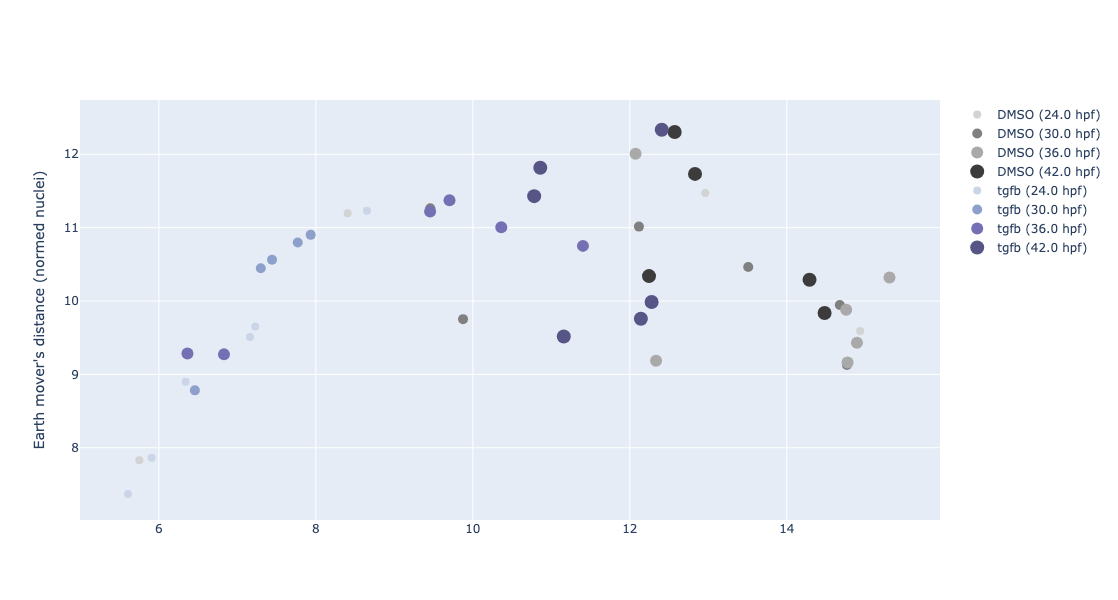

In [38]:
# get upper and lower quartile estimates for DMSO control
# dmso_ft = (dist_df["chem_id"] == "DMSO") & (dist_df["cohort"] == tg) & (~outlier_flag)
# q1 = np.percentile(dist_df.loc[dmso_ft, stat], 25)
# q3 = np.percentile(dist_df.loc[dmso_ft, stat], 75)


fig = go.Figure()
for tg in [cohort_list[0]]:
    for p, pert in enumerate(pert_key):
        if ("DMSO" in pert) | ("tgfb" in pert) :
            ft = (dist_df["chem_i"] == pert) & (dist_df["cohort"] == tg) & (dist_df["chem_time"] < 55) & (~outlier_flag)
            if np.any(ft):
                indices = dist_df.index[ft]
                chem_i = dist_df.loc[indices[0], "chem_i"]
                time = dist_df.loc[indices[0], "chem_time"]
                name = dist_df.loc[indices[0], "chem_id"] + f" ({time} hpf)"
                fig.add_trace(go.Scatter(
                    x=embedding[ft, 0],
                    y=embedding[ft, 1],
                    name=name,
                    marker_color=color_dict[chem_i], 
                    # fillcolor=color_dict[chem_i],
                    opacity=1,
                    line_color="black", mode="markers", marker=dict(size=time/3)
                ))

# fig.add_hrect(y0=q1, y1=q3, line_width=1, fillcolor="gray", opacity=0.3, line_color="black")
# fig.update_layout(xaxis=dict(range=[-120, 120]))
fig.update_layout(
    yaxis_title=y_axis_list[s],
    boxmode='group',
    autosize=False,
    width=1000,
    height=600,# group together boxes of the different traces for each value of x
)

fig.show()